In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import importlib
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics
from keras.models import Model
from keras.applications import VGG16
from PIL import Image
import keras.backend as K

Using TensorFlow backend.


In [2]:
resultspath = '<directory where you want to store the images>'

## Recreate Content

In [3]:
img = Image.open('hugo.jpg')
img.size

(512, 512)

In [4]:
mean_sub = np.array([123.68, 116.779, 103.939], dtype=np.float32)
pre_processing = lambda x: (x - mean_sub)[:,:,:,::-1]

In [5]:
de_preprocess = lambda x, shape: np.clip(x.reshape(shape)[:,:,:,::-1] + mean_sub, 0, 255)

In [6]:
img_arr = pre_processing(np.expand_dims(np.array(img), 0))
shape_content = img_arr.shape

shape_content

(1, 512, 512, 3)

In [23]:
model = VGG16(weights='imagenet', include_top=False)

In [24]:
layer = model.get_layer('block2_conv2').output

In [25]:
layer

<tf.Tensor 'Relu_16:0' shape=(?, ?, ?, 128) dtype=float32>

In [26]:
layer_model = Model(model.input, layer)

In [87]:
target = K.variable(layer_model.predict(img_arr))
content_target = target

content_target

In [7]:
class Evaluator(object):
    def __init__(self, f, shp): self.f, self.shp = f, shp
        
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)

    def grads(self, x): return self.grad_values.flatten().astype(np.float64)

In [29]:
loss = metrics.mse(layer, target)
grads = K.gradients(loss, model.input)
fn = K.function([model.input], [loss] + grads)
evaluator = Evaluator(fn, shape_content)

In [8]:
def solve_image(eval_obj, niter, x, path):
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127, 127)
        print ('Minimum Loss Value:', min_val)
        imsave('{}res_at_iteration_{}.png'.format(path, i), de_preprocess(x.copy(), shape_content)[0])
    return x

((1, 512, 512, 3), (1, 512, 512, 3))

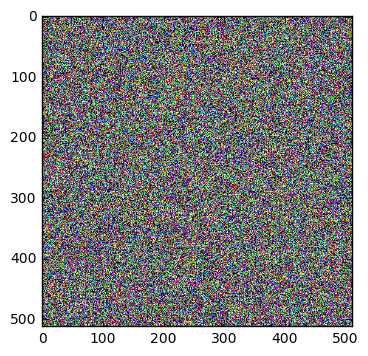

In [31]:
def rand_img(shape):
    return np.random.uniform(-2.5, 2.5, shape) / 100

x = rand_img(shape_content)
plt.imshow(x[0])

x.shape, img_arr.shape

In [32]:
x = solve_image(evaluator, 10, x, resultspath+'content/')

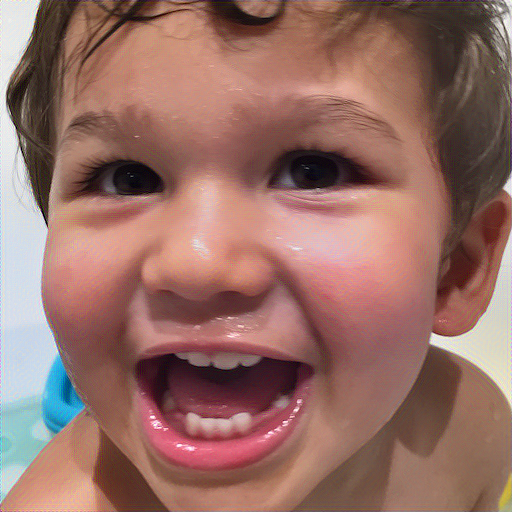

In [43]:
Image.open(resultspath+'res_at_iteration_9.png')

## Recreate Style

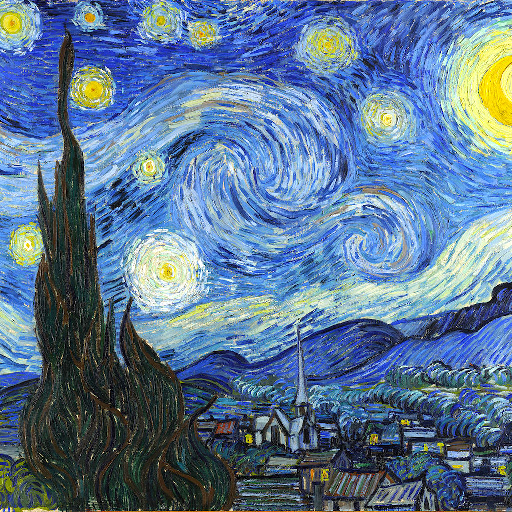

In [26]:
style = Image.open('starry_night.jpg')
if style.size != img.size:
    style = style.resize(img.size, Image.ANTIALIAS)
style

In [27]:
style_arr = pre_processing(np.expand_dims(np.array(style), 0))
style_shape = style_arr.shape
style_shape

(1, 512, 512, 3)

In [28]:
model = VGG16(weights='imagenet', include_top=False, input_shape=style_shape[1:])

In [29]:
outputs = {layer.name:layer.output for layer in model.layers}
outputs

{'block1_conv1': <tf.Tensor 'Relu_13:0' shape=(?, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'Relu_14:0' shape=(?, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'MaxPool_5:0' shape=(?, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'Relu_15:0' shape=(?, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'Relu_16:0' shape=(?, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'MaxPool_6:0' shape=(?, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'Relu_17:0' shape=(?, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'Relu_18:0' shape=(?, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'Relu_19:0' shape=(?, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'MaxPool_7:0' shape=(?, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'Relu_20:0' shape=(?, 64, 64, 512) dtype=float32>,
 'block4_conv2': <tf.Tensor 'Relu_21:0' shape=(?, 64, 64, 512) dtype=float32>,
 'block4_conv3': <tf.Tensor 'Relu_

In [30]:
temp = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']
style_layers = [outputs[i] for i in temp]
style_layers

[<tf.Tensor 'Relu_14:0' shape=(?, 512, 512, 64) dtype=float32>,
 <tf.Tensor 'Relu_16:0' shape=(?, 256, 256, 128) dtype=float32>,
 <tf.Tensor 'Relu_19:0' shape=(?, 128, 128, 256) dtype=float32>,
 <tf.Tensor 'Relu_22:0' shape=(?, 64, 64, 512) dtype=float32>,
 <tf.Tensor 'Relu_25:0' shape=(?, 32, 32, 512) dtype=float32>]

In [31]:
style_model = Model(model.input, style_layers)

In [32]:
style_target = [K.variable(i) for i in style_model.predict(style_arr)]
style_target

In [33]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

In [34]:
def style_loss(x, targ):
    return metrics.mse(gram_matrix(x), gram_matrix(targ))

In [78]:
loss = sum(style_loss(l[0], t[0]) for l, t in zip(style_layers, style_target))
grads = K.gradients(loss, model.input)
fn = K.function([model.input], [loss] + grads)
evaluator = Evaluator(fn, style_shape)

((1, 512, 512, 3), (1, 512, 512, 3))

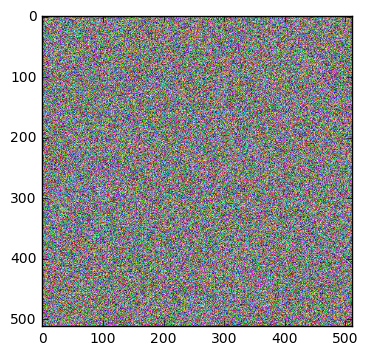

In [18]:
import scipy

def rand_img(shape):
    return np.random.uniform(-2.5, 2.5, shape)

x = rand_img(style_shape)
# Guassian Blur
# Helps in reducing image noise and image detail
# x = scipy.ndimage.filters.gaussian_filter(x, [0,2,2,0])
plt.imshow(x[0])

x.shape, style_shape

In [85]:
solve_image(evaluator, 10, x, resultspath+'style/')

array([  52.77472636,   96.05478733,  110.27180966,   48.50377179,
         91.66147232,  116.58318728,   44.89962632,   86.38650044,
        124.97309967,   35.38175262,   86.82875458,  125.6790267 ,
         27.24150589,   86.13090468,  127.        ,   22.8072726 ,
         92.60634576,  127.        ,   36.98444286,  100.12599225, ...,
         -0.88475194,   -6.52234221,    0.1357612 ,  -13.49971612,
        -25.57253409,   -9.37364083,  -32.94114389,  -35.46057445,
        -17.48381369,  -40.16616163,  -34.89199723,  -16.93823035,
        -34.14613452,  -31.507405  ,  -14.95239127,  -26.62755075,
        -23.48178122,   -8.77503616,  -16.25091441,  -18.35497705])

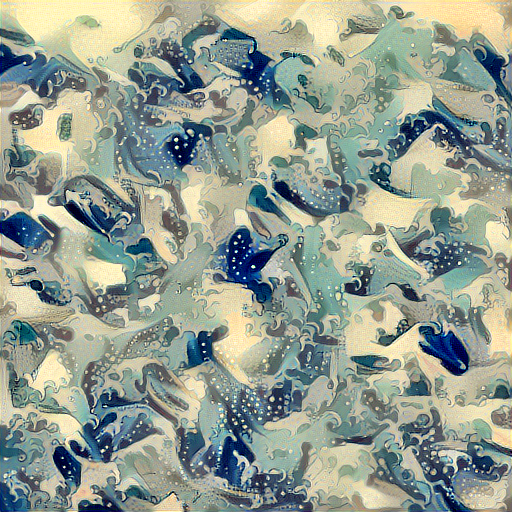

In [86]:
Image.open(resultspath+'style/res_at_iteration_9.png')

## Style Transfer

In [35]:
shape_content, style_shape

((1, 512, 512, 3), (1, 512, 512, 3))

In [36]:
content_layer = outputs['block2_conv2']
content_model = Model(model.input, content_layer)
content_target = content_model.predict(img_arr)

In [37]:
style_weights = [0.05,0.2,0.2,0.25,0.3]
total_loss = sum(style_loss(l[0], t[0])*w for l, t, w in zip(style_layers, style_target, style_weights))
total_loss += metrics.mse(content_layer, content_target)/10

grads = K.gradients(total_loss, model.input)
fn = K.function([model.input], [total_loss] + grads)
evaluator = Evaluator(fn, style_shape)

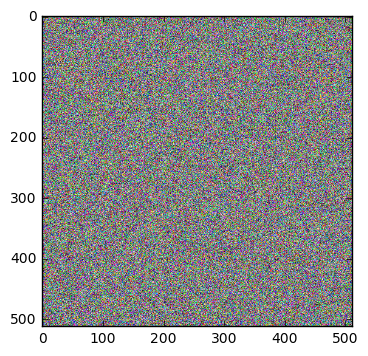

In [38]:
x = rand_img(style_shape)
plt.imshow(x[0])

In [39]:
solve_image(evaluator, 10, x, resultspath+'starry_baby_transfer/')

array([   2.25977171,   41.70786169,   -7.91919082,  112.33384477,
        127.        ,  117.38978486,  126.81611318,  127.        ,
        127.        ,   37.25454115,  108.31999599,   62.73826501,
          4.47233839,   79.20956918,   36.40597384,   55.75223409,
        127.        ,  101.50664827,   15.53055345,  113.87637691, ...,
          8.29754741,  -57.20953378,   10.04572362,  -15.64010785,
        -72.49846664,   32.46495036,   10.31334311,  -24.03684954,
         -6.39598313,  -19.28034638,  -74.96392417,   15.26655551,
         16.96649734,  -49.26380658,   10.47133151,    5.9726909 ,
        -59.4849422 ,   18.48775545,   11.72613603,  -29.01461098])